In [2]:
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

## Прогнозирование временного ряда моделью MLP

__Функция разделения данных на обучение и тест__

In [47]:
# функция разделения данных на 
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

__Преобразование данных в контролируемую задачу обучения__

In [48]:
# преобразование данных в контролируемую задачу обучения
def series_to_supervised(data, n_in, n_out=1):
    df = pd.DataFrame(data)
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg.values

__Функция создания дифференцированного ряда (убираем тренд и сезонность)__

In [49]:
# функция создания дифференцированного ряда (убираем тренд и сезонность)
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    diff = np.array(diff)
    return diff

In [50]:
# инвертировать разностное значение (возвращаем удаленную компоненту ряда)
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

__Функция масштабирования обучающих и тестовых данных__

In [51]:
# масштабирование
def scale(data):
    data_reshape = data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(data_reshape)
    scaled_data = scaler.transform(data_reshape)
    return scaler, scaled_data

In [52]:
# инвертирование масштабирования
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

__Оценка модели (RMSE)__

In [53]:
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

__Обучение модели__

In [54]:
# обучение модели
def model_fit(train, config):
    # параметры конфигурации модели
    n_input, n_nodes, n_epochs, n_batch = config
    # преобразование данных в контролируемую задачу обучения
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    # формирование модели
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # обучение
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

__Построение прогноза__

In [55]:
# функция построения прогноза
def model_predict(model, history, config):
    # параметры конфигурации
    n_input, _, _, _ = config
    # формирование данных для прогноза
    x_input = array(history[-n_input:]).reshape(1, n_input)
    # прогноз
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

__Пошаговая проверка одномерных данных__

In [79]:
def walk_forward_validation(data, n_test, cfg):
    # список для тестирования
    predictions_test = list()
    # вектор из X
    x_temp = np.array([])
    # прогноз на n - шагов вперед
    predictions = list()
    # масштабирование данных
    scaler, scaled_data = scale(data)
    # разделение данных на обучение, тест (n_test - количество объектов тестовую выборку)
    train, test = train_test_split(scaled_data, n_test)
    # обучение модели
    model = model_fit(train, cfg)
    # формирование списка исторических данных из train
    history_train = [x for x in train]
    # формирования списка исторических данных из test
    history_test = [x for x in test]
    # пошаговое построение одинарных прогнозов по размеру тестовой выборки
    for i in range(len(test)):
        # построение одношагового прогноза
        yhat = model_predict(model, history_train, cfg)
        # инвертирование масштабирования
        yhat = invert_scale(scaler, history_train, yhat)
        # записть прогноза в список
        predictions_test.append(yhat)
        # добавление значения из тестовой выборки в исторические данные для построения дальнейших прогнозов
        history_train.append(test[i])
    # рассчет метрики модели
    rmse = measure_rmse(data[-n_test:].reshape(1,-1)[0], predictions_test)
    result_rmse = pd.Series({"Оценка модели на тестовой выборке: RMSE": rmse})
    return result_rmse, predictions_test

__Обучение и оценка модели__

In [77]:
df = pd.read_excel("D:/Datasets/regression/all_fact16-20.xlsx", engine="openpyxl")
data = df['all'].values[:60]

# задаем индекс временного ряда
index_series = pd.date_range('2016-01-31', freq='M', periods=60)

# данные для графика (преобразуем в фрейм данных с нужным индексом)
series_graph = pd.DataFrame({'All':data}, index=index_series)
data = data.reshape(-1, 1)
series_graph.head(), data[:5]

(                    All
 2016-01-31  1239.807717
 2016-02-29  1082.035863
 2016-03-31  1104.730841
 2016-04-30   897.962429
 2016-05-31   840.153646,
 array([[1239.807717],
        [1082.035863],
        [1104.730841],
        [ 897.962429],
        [ 840.153646]]))

In [83]:
# параметры config:
# 1. n_input - количество наблюдений с запаздыванием, которые будут использоваться в качестве входных данных для модели.
# 2. n_nodes - количество узлов, которые будут использоваться в скрытом слое.
# 3. n_epochs - количество раз, когда необходимо подвергнуть модель воздействию всего обучающего набора данных.
# 4. n_batch - количество выборок в течение периода, после которого веса обновляются.

n_input = 3
n_nodes = 200
n_epochs = 1000
n_batch = 250
# размер тестовой выборки
n_test = 12
# конфигурация параметров
config = [n_input, n_nodes, n_epochs, n_batch]

rmse, predictions = walk_forward_validation(data, n_test, config)
rmse

Оценка модели на тестовой выборке: RMSE    78.701159
dtype: float64

__График моделирования на тестовой выборке__

<AxesSubplot:title={'center':'Прогноз на тестовой выборке модели MLP'}, xlabel='Месяцы', ylabel='Потребление'>

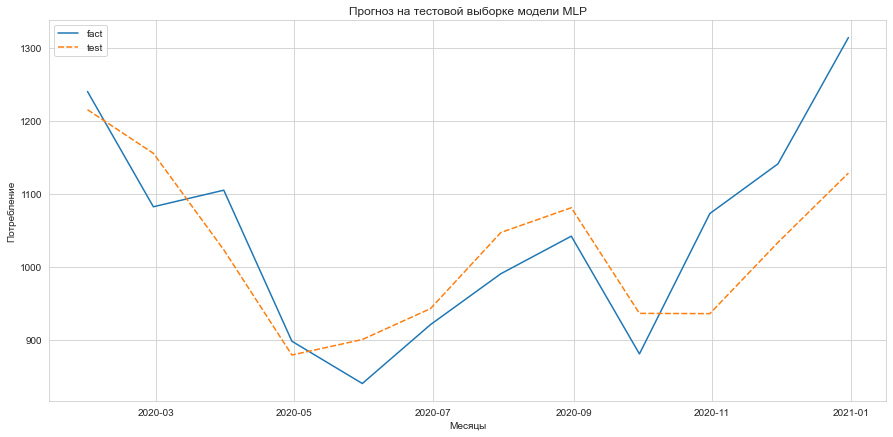

In [84]:
index_series = pd.date_range('2020-01-01', freq='M', periods=12)
df_line = pd.DataFrame({'fact': series_graph.values[:12].reshape(1,-1)[0],
                        'test': predictions}, index=index_series)

fig, ax = plt.subplots(figsize=(15,7))
sns.set_style('whitegrid', {'axes.grid': True})
plt.grid(True)
ax.set_title('Прогноз на тестовой выборке модели MLP')
plt.xlabel('Месяцы')
plt.ylabel('Потребление')

sns.lineplot(data=df_line)

Модель многослойного персептрона (MLP) в среднем ошибается на 78 млн.кВт ч. Модель не плохо улавливает тенденцию временного ряда. Однако такое отклонение от исходного временного ряда остается достаточно большим. Такой результат обусловлен:  

- маленьким объемом исходных данных
- особенностью структуры модели  

В структуре MLP в отличии от LSTM не учитывается механизм памяти для хранения информации за предыдущее временные шаги. Однако модель лучше справилась чем LSTM. Также на MLP влияет ключевое ограничение, в виде диапазона временной корреляции между наблюдениями. Он должен быть четко указан при моделировании. Модель многослойного персептрона может использоваться как отправная точка для моделирования задач предсказания последовательности.